In [ ]:
!pip install torchmetrics

In [1]:
# this line copies labels.csv and move it to colab temporary directory for efficiency
!cp "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset/archive/chest_xray/labels.csv" /content/

In [ ]:
# this command copies all the images to colabs temporary directory for efficiency
%cd "/content"
%cp -av "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset/archive/chest_xray/img_dir" .

In [12]:
import os
import time, copy
import pandas as pd
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy

# csv file containing filename and correct label
annotations_file = "/content/labels.csv"

# directory containing all images
img_dir = "/content/img_dir"

# hyperparameters
batch_size = 64
image_size = 128
nc = 3 # number of channels
nf = 64 # number of features to begin with
dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
root = "/content/drive/MyDrive/Doutorado/Deep Learning MIT/Chest_X_Ray Pneumonia Dataset"

In [14]:
# setup transforms and Dataset
transform = transforms.Compose([
                               transforms.Resize(image_size, antialias=True),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

class ChestXRayDataset(Dataset):
    def __init__(self, annotations_file, img_dir=img_dir, transform=transform, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, usecols=['filename','label'])      
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform: 
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.to(device), label

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# setup model
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class XRayClassifier(nn.Module):
    def __init__(self, nc=nc, nf=nf, dropout=dropout):
        super(XRayClassifier, self).__init__()

        self.pipeline = nn.Sequential(
            ResNetBlock(nc,   nf,    stride=2), # (B, C, H, W) -> (B, NF, H/2, W/2), i.e., (64,64,64,64)
            ResNetBlock(nf,   nf*2,  stride=2), # (64,128,32,32)
            ResNetBlock(nf*2, nf*4,  stride=2), # (64,256,16,16)
            ResNetBlock(nf*4, nf*8,  stride=2), # (64,512,8,8)
            ResNetBlock(nf*8, nf*16, stride=2), # (64,1024,4,4)
            nn.Conv2d(nf*16, 1, 4, 1, 0, bias=False),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.pipeline(input.to(device))

In [16]:
# inspect labels
labels_df = pd.read_csv(annotations_file, usecols=['filename','label'])

# split the data into training and testing sets
train_val_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# split the training and validation data
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# write files
train_df.to_csv('train_set.csv')
val_df.to_csv('val_set.csv')
test_df.to_csv('test_set.csv')

In [17]:
# Prepare datasets
train_set = ChestXRayDataset('train_set.csv')
val_set = ChestXRayDataset('val_set.csv')
test_set = ChestXRayDataset('test_set.csv')
full_set = ChestXRayDataset(annotations_file)

# Prepare dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_dataloader,
               'val': val_dataloader,
               'test': test_dataloader}

dataset_sizes = {'train': len(train_set),
                 'val': len(val_set),
                 'test': len(test_set)}

In [18]:
dataset_sizes

{'train': 3750, 'val': 938, 'test': 1172}

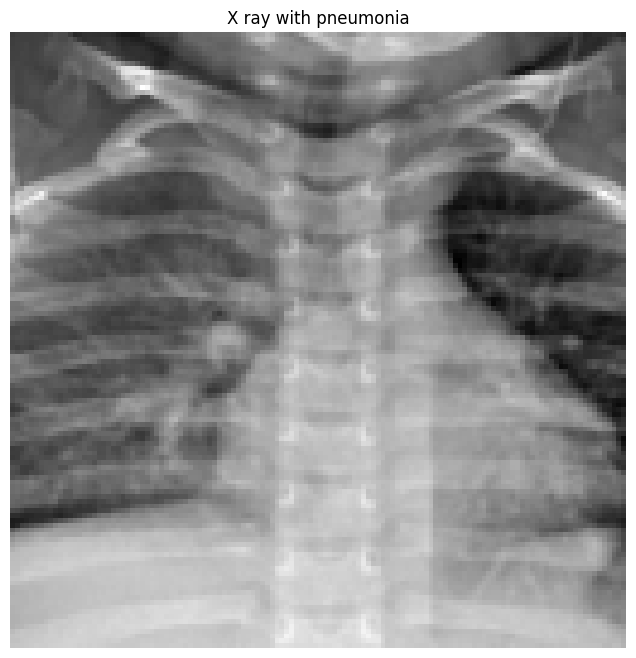

In [19]:
import random
import matplotlib.pyplot as plt
import torchvision.utils as vutils

idx = random.randint(0, dataset_sizes['train'])
img = train_set[idx][0]
label = train_set[idx][1]

# data visualization
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title(f"{'X ray with pneumonia' if label == 1 else 'X ray without pneumonia'}")
plt.imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).cpu(),(1,2,0)))

In [20]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=5, threshold=0.5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0
    best_f1 = 0

    # initialize metric
    f1 = BinaryF1Score(threshold=threshold).to(device)
    acc = BinaryAccuracy(threshold=threshold).to(device)

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
        training_curves[phase+'_f1'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            since_phase = time.time()
                        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.view(-1), labels.to(torch.float))

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                f1_score = f1(outputs.view(-1), labels)
                acc_score = acc(outputs.view(-1), labels)
                            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = acc.compute()
            epoch_f1 = f1.compute()
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)       
            training_curves[phase+'_f1'].append(epoch_f1)
            phase_time_elapsed = time.time() - since_phase

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Time elapsed: {phase_time_elapsed // 60:.0f}m {phase_time_elapsed % 60:.0f}s')

            # deep copy the model if it's the best F1
            if phase == 'val' and epoch_f1 > best_f1:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              best_f1 = epoch_f1

            # reset metrics
            f1.reset()
            acc.reset()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch} with F1-score: {best_f1}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [21]:
learning_rate = 0.0001
num_epochs = 5
dropout = 0.2
weight_decay = 0

model = XRayClassifier().to(device)
criterion = nn.BCELoss() # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/5
----------
train Loss: 0.3705 Acc: 0.7867 F1: 0.8393 Time elapsed: 1m 20s
val   Loss: 0.2295 Acc: 0.9136 F1: 0.9438 Time elapsed: 0m 17s
test  Loss: 0.2590 Acc: 0.8993 F1: 0.9347 Time elapsed: 0m 24s

Epoch 2/5
----------
train Loss: 0.2074 Acc: 0.8299 F1: 0.8709 Time elapsed: 1m 13s
val   Loss: 0.1872 Acc: 0.9296 F1: 0.9509 Time elapsed: 0m 20s
test  Loss: 0.1743 Acc: 0.9360 F1: 0.9549 Time elapsed: 0m 21s

Epoch 3/5
----------
train Loss: 0.1601 Acc: 0.8491 F1: 0.8856 Time elapsed: 1m 11s
val   Loss: 0.1458 Acc: 0.9510 F1: 0.9666 Time elapsed: 0m 18s
test  Loss: 0.1563 Acc: 0.9462 F1: 0.9634 Time elapsed: 0m 21s

Epoch 4/5
----------
train Loss: 0.1491 Acc: 0.8429 F1: 0.8797 Time elapsed: 1m 11s
val   Loss: 0.1599 Acc: 0.9520 F1: 0.9673 Time elapsed: 0m 18s
test  Loss: 0.1469 Acc: 0.9505 F1: 0.9660 Time elapsed: 0m 21s

Epoch 5/5
----------
train Loss: 0.1366 Acc: 0.8563 F1: 0.8910 Time elapsed: 1m 12s
val   Loss: 0.1464 Acc: 0.9542 F1: 0.9689 Time elapsed: 0m 18s
test  Lo

In [22]:
models_path = os.path.join(root, 'models', f'chestxray_classifier.model')
torch.save(model.state_dict(), models_path)

In [23]:
import sklearn.metrics as metrics

# Utility functions for plotting your results!
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc', 'f1']):
    epochs = list(range(1, len(training_curves['train_loss'])+1))
    fig, axs = plt.subplots(len(metrics), 1, figsize=(5, 10), tight_layout=True)
    for idx, metric in enumerate(metrics):
        ax = axs[idx]     
        ax.set_title(f'Training curves - {metric}')
        ax.set_ylabel(metric)
        ax.xaxis.set_ticks(np.arange(1, len(epochs)+1, 1))
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc' or metric == 'f1':
                    ax.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    ax.plot(epochs, training_curves[key])
        ax.set_xlabel('epoch')
        ax.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.where(outputs < 0.5, 0, 1).view(-1)
        scores = outputs.view(-1)
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0).view(-1)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


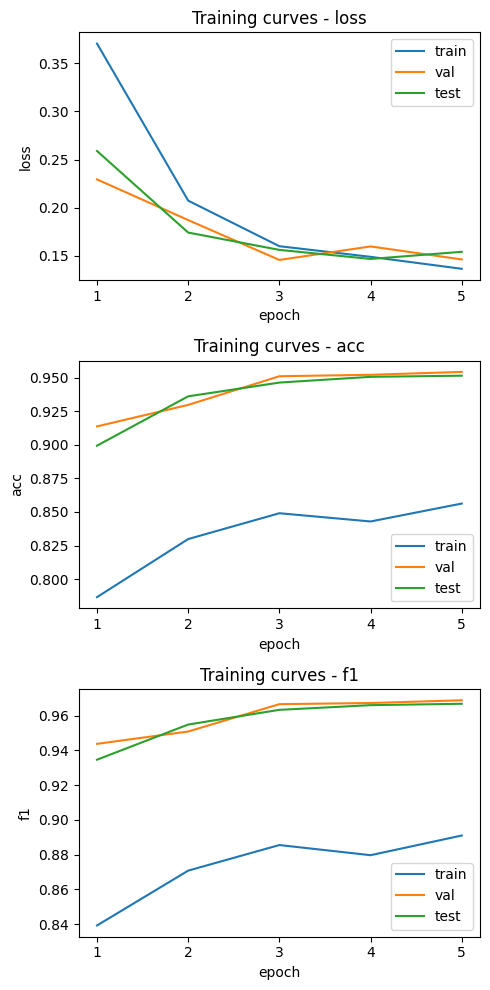

In [24]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

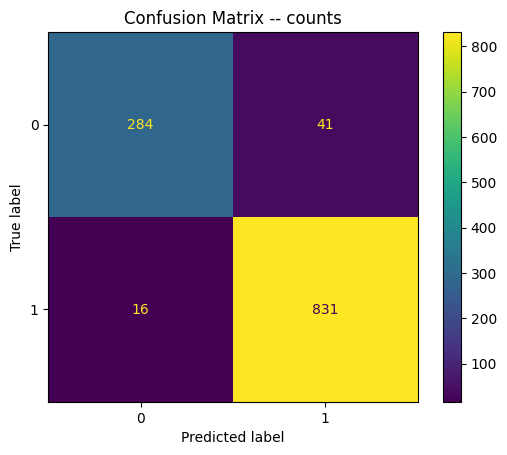

In [25]:
res = plot_cm(model, device, dataloaders, phase='test')